In [1]:
import qiskit 
print(qiskit.__version__)

1.3.1


### Knapsack

In [4]:
# basic imports

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# quantum imports
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.applications import Maxcut, Knapsack
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import QAOAAnsatz
# SciPy minimizer routine
from scipy.optimize import minimize
from qiskit.primitives import BackendEstimatorV2, BackendSamplerV2
from qiskit_aer import AerSimulator
backend = AerSimulator(method='automatic')


estimator = BackendEstimatorV2(backend=backend)
sampler = BackendSamplerV2(backend=backend)

### Generate a Random Instance

In [5]:
# Parameters for the knapsack problem
num_items = 5
max_weight = 10

# Generate random weights and values for the items

weights = np.random.randint(1, 10, size=num_items)
values = np.random.randint(10, 50, size=num_items)

# Capacity of the knapsack
capacity = int(0.6 * np.sum(weights))

print(f"Weights: {weights}")
print(f"Values: {values}")
print(f"Capacity: {capacity}")

# Create the Knapsack problem
knapsack = Knapsack(values.tolist(), weights.tolist(), capacity)

# Convert the problem to a QuadraticProgram
problem = knapsack.to_quadratic_program()
print(problem.prettyprint())

Weights: [2 3 2 9 9]
Values: [26 45 11 45 40]
Capacity: 15
Problem name: Knapsack

Maximize
  26*x_0 + 45*x_1 + 11*x_2 + 45*x_3 + 40*x_4

Subject to
  Linear constraints (1)
    2*x_0 + 3*x_1 + 2*x_2 + 9*x_3 + 9*x_4 <= 15  'c0'

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



### Exact Solution

In [6]:
# Solve the problem using CplexOptimizer
optimizer = CplexOptimizer()
result = optimizer.solve(problem)

print("Solution:")
print(result.fval)
print(result.x)

Solution:
116.0
[1. 1. 0. 1. 0.]


In [7]:
# problem to qubo
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Minimize
 obj: - 10106 x_0 - 15165 x_1 - 10091 x_2 - 45405 x_3 - 45400 x_4
      - 5040 c0@int_slack@0 - 10080 c0@int_slack@1 - 20160 c0@int_slack@2
      - 40320 c0@int_slack@3 + [ 1344 x_0^2 + 4032 x_0*x_1 + 2688 x_0*x_2
      + 12096 x_0*x_3 + 12096 x_0*x_4 + 1344 x_0*c0@int_slack@0
      + 2688 x_0*c0@int_slack@1 + 5376 x_0*c0@int_slack@2
      + 10752 x_0*c0@int_slack@3 + 3024 x_1^2 + 4032 x_1*x_2 + 18144 x_1*x_3
      + 18144 x_1*x_4 + 2016 x_1*c0@int_slack@0 + 4032 x_1*c0@int_slack@1
      + 8064 x_1*c0@int_slack@2 + 16128 x_1*c0@int_slack@3 + 1344 x_2^2
      + 12096 x_2*x_3 + 12096 x_2*x_4 + 1344 x_2*c0@int_slack@0
      + 2688 x_2*c0@int_slack@1 + 5376 x_2*c0@int_slack@2
      + 10752 x_2*c0@int_slack@3 + 27216 x_3^2 + 54432 x_3*x_4
      + 6048 x_3*c0@int_slack@0 + 12096 x_3*c0@int_slack@1
      + 24192 x_3*c0@int_slack@2 + 48384 x_3*c0@int_slack@3 + 27216 x_4^2
      + 6048 x_4*c0@int_s

In [8]:
num_vars = qubo.get_num_vars()
print(f"Number of variables: {num_vars}")

Number of variables: 9


In [9]:
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 15204.5
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1667. +0.j, -2497.5+0.j, -1674.5+0.j, -7537.5+0.j, -7540. +0.j,
  -840. +0.j, -1680. +0.j, -3360. +0.j, -6720. +0.j,   504. +0.j,
   336. +0.j,  1512. +0.j,  1512. +0.j,   168. +0.j,   336. +0.j,
   672. +0.j,  1344. +0.j,   504. +0.j,  2268. +0.j,  2268. +0.j,
   252. +0.j,   504. +0.j,  1008. +0.j,  2016. +0.j,  1512. +0.j,
  1512. +0.j,

### QAOA

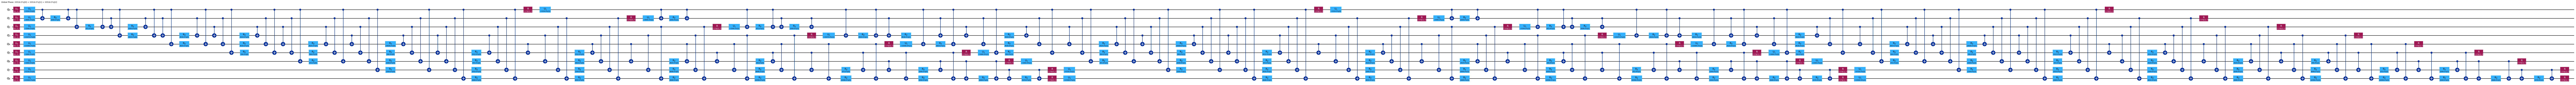

In [14]:
reps =3
circuit = QAOAAnsatz(cost_operator=qubitOp, reps=reps)
#circuit.measure_all()
circuit = circuit.decompose(reps=3)
circuit.draw('mpl',fold=-1)

#### Execute

In [15]:
initial_gamma = np.pi
initial_beta = np.pi/2

init_params = [initial_gamma, initial_beta]*reps
print(init_params)

[3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966]


In [16]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [22]:
objective_func_vals = [] # Store the objective function values

result = minimize(
    cost_func_estimator,
    init_params,
    args= (circuit, qubitOp, estimator),
    method="COBYLA",
    tol=1e-2
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -350.433349609375
       x: [ 3.145e+00  2.363e+00  2.999e+00  1.567e+00  3.138e+00
            2.567e+00]
    nfev: 33
   maxcv: 0.0


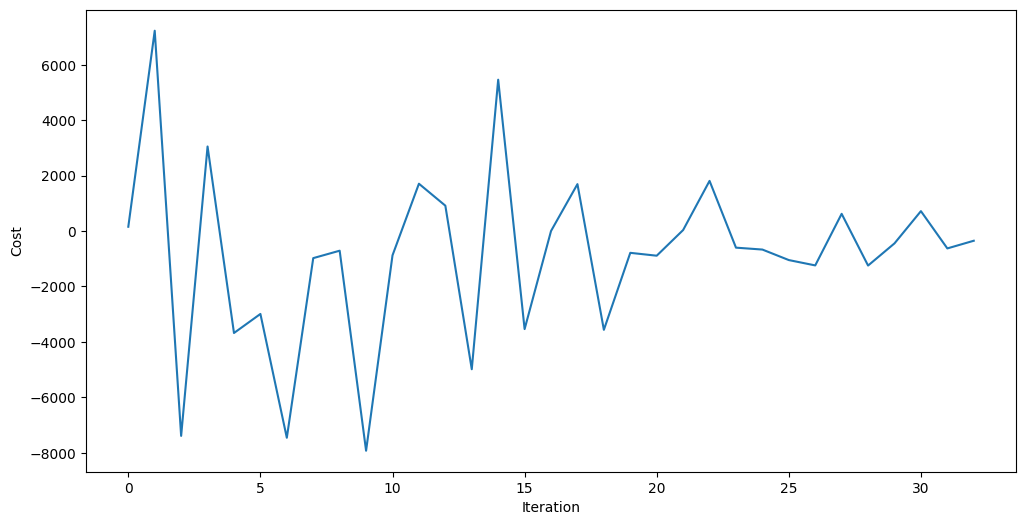

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

### Post Processing

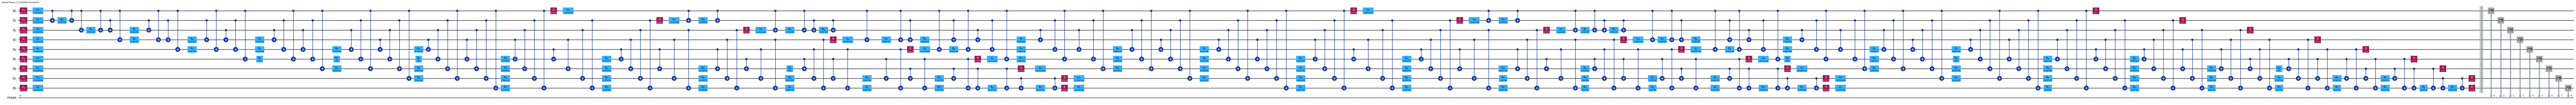

In [24]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit.measure_all()
optimized_circuit.draw('mpl', idle_wires=False,fold=-1)

In [25]:
pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

In [26]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_vars)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 1, 0, 0, 1, 0, 0, 0]


In [27]:


# Find the indices of the top 4 values
top_4_indices = np.argsort(np.abs(values))[::-1][:4]
top_4_results = []
# Print the top 4 results with their probabilities
print("Top 4 Results:")
for idx in top_4_indices:
    bitstring = to_bitstring(keys[idx], num_vars)
    bitstring.reverse()
    top_4_results.append(bitstring)
    print(f"Bitstring: {bitstring}, Probability: {values[idx]:.6f}")


Top 4 Results:
Bitstring: [1, 0, 1, 0, 0, 1, 0, 0, 0], Probability: 0.018600
Bitstring: [1, 1, 0, 1, 0, 0, 0, 1, 0], Probability: 0.017700
Bitstring: [0, 1, 0, 0, 1, 1, 0, 0, 0], Probability: 0.012600
Bitstring: [0, 1, 0, 1, 0, 1, 1, 0, 0], Probability: 0.012400


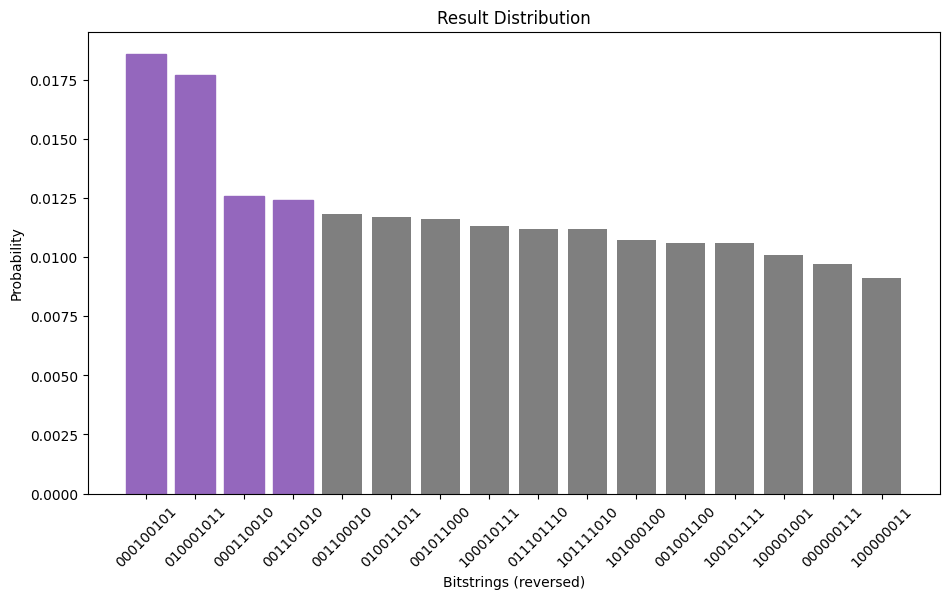

In [28]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Update matplotlib font size
matplotlib.rcParams.update({"font.size": 10})

# Assuming final_distribution_bin is defined elsewhere
final_bits = final_distribution_bin  

# Get the absolute values and sort to extract the top 16 and top 4 values
values = np.abs(list(final_bits.values()))
top_16_values = sorted(values, reverse=True)[:16]
top_4_values = sorted(values, reverse=True)[:4]

# Filter the top 16 bitstrings and their probabilities
top_16_bitstrings = []
top_16_probabilities = []

for bitstring, value in final_bits.items():
    if abs(value) in top_16_values:
        top_16_bitstrings.append(bitstring)
        top_16_probabilities.append(value)

# Sort the top 16 by probability for better visualization
sorted_indices = np.argsort(top_16_probabilities)[::-1]
top_16_bitstrings = [top_16_bitstrings[i] for i in sorted_indices]
top_16_probabilities = [top_16_probabilities[i] for i in sorted_indices]

# Plot the top 16 values
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(top_16_bitstrings, top_16_probabilities, color="tab:grey")

# Highlight the top 4 bars in purple
for i, bar in enumerate(bars):
    if top_16_probabilities[i] in top_4_values:
        bar.set_color("tab:purple")

plt.show()


### Convert QUBO Solution to the Problem Solution

In [29]:
result = converter.interpret(most_likely_bitstring)
cost = problem.objective.evaluate(result)
feasible =problem.get_feasibility_info(result)[0]


print("Result knapsack:", result)
print("Result value:", cost)
print("Feasible:", feasible)

Result knapsack: [1. 0. 1. 0. 0.]
Result value: 37.0
Feasible: True


In [30]:
# Iterate through the list of bitstrings and evaluate for each
for bitstring in top_4_results:
    result = converter.interpret(bitstring)  # Interpret the bitstring
    cost = problem.objective.evaluate(result)  # Evaluate the cost for the bitstring
    feasible =problem.get_feasibility_info(result)[0]
    
    # Print the results
    print("Result knapsack:", result)
    print("Result value:", cost)
    print("Feasible solution:", feasible)


Result knapsack: [1. 0. 1. 0. 0.]
Result value: 37.0
Feasible solution: True
Result knapsack: [1. 1. 0. 1. 0.]
Result value: 116.0
Feasible solution: True
Result knapsack: [0. 1. 0. 0. 1.]
Result value: 85.0
Feasible solution: True
Result knapsack: [0. 1. 0. 1. 0.]
Result value: 90.0
Feasible solution: True
